In [1]:
# ============================= PATH SETUP =============================
# Choose ONE of the following blocks depending on where you run the notebook.
# ------------------------------------------------------------------------------

from pathlib import Path
import sys

# ------------------------------------------------------------------------------
# OPTION A — Google Colab (recommended if reproducing from the paper)
# ------------------------------------------------------------------------------
# If you are running on Google Colab, UNCOMMENT this block.


from google.colab import drive
drive.mount("/content/drive")

ROOT = Path("/content/drive/MyDrive/mbrl-testing-frameworks-empirical-study")


# ------------------------------------------------------------------------------
# OPTION B — Local machine (GitHub clone)
# ------------------------------------------------------------------------------
# If you are running locally (e.g., after `git clone`), UNCOMMENT this block.
"""
ROOT = Path("mbrl-testing-frameworks-empirical-study")
"""
# ------------------------------------------------------------------------------
# Shared paths (DO NOT EDIT BELOW)
# ------------------------------------------------------------------------------

AGENT_ROOT  = ROOT / "agents" / "dynaq" / "taxi"
RESULTS_DIR = ROOT / "results" / "taxi"
TABLES_DIR  = RESULTS_DIR / "tables"
FIGS_DIR    = RESULTS_DIR / "figs"
RAW_DIR     = RESULTS_DIR / "raw_single"

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)
FIGS_DIR.mkdir(parents=True, exist_ok=True)
RAW_DIR.mkdir(parents=True, exist_ok=True)

if str(AGENT_ROOT) not in sys.path:
    sys.path.insert(0, str(AGENT_ROOT))

print("AGENT_ROOT :", AGENT_ROOT)
print("RESULTS_DIR:", RESULTS_DIR)

Mounted at /content/drive
AGENT_ROOT : /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/agents/dynaq/taxi
RESULTS_DIR: /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/taxi


In [2]:
import os
import time
import json
import math
import random
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os, json, math, random, pickle, re, time
from typing import Dict, List, Tuple
from tqdm import trange, tqdm

# -------------------------------
# Reproducibility (do NOT change)
# -------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [3]:
#Taxi environment + fixed Dyna-Q agent
# =========================================================

import gymnasium as gym
import json
import numpy as np
import random
from pathlib import Path


np.random.seed(SEED)
random.seed(SEED)


env = gym.make("Taxi-v3")
env.reset(seed=SEED)

N_STATES  = env.observation_space.n
N_ACTIONS = env.action_space.n
HORIZON   = 200

AGENT_Q_PATH   = AGENT_ROOT / "dynaq_q.npy"
AGENT_CFG_PATH = AGENT_ROOT / "dynaq_config.json"

if not AGENT_Q_PATH.exists():
    raise FileNotFoundError(
        f"Fixed agent not found at {AGENT_Q_PATH}. "
        "Training is intentionally disabled for reproducibility."
    )

Q = np.load(AGENT_Q_PATH)

if AGENT_CFG_PATH.exists():
    with open(AGENT_CFG_PATH, "r") as f:
        qcfg = json.load(f)
else:
    qcfg = {}

print("Loaded fixed Dyna-Q agent from:", AGENT_Q_PATH)
print("Agent config:", qcfg)
print("Q-table shape:", Q.shape)

Loaded fixed Dyna-Q agent from: /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/agents/dynaq/taxi/dynaq_q.npy
Agent config: {'episodes': 8000, 'alpha': 0.1, 'gamma': 0.99, 'epsilon_end': 0.01, 'plan_steps': 20, 'mean_train_return_last_100': 7.01}
Q-table shape: (500, 6)


In [4]:
# Runner, evaluator, metrics
# =========================================================

from typing import List, Dict

ALL_RESULTS = []


def add_result_row(framework: str, profile: str, summary: dict):

    ALL_RESULTS.append({
        "framework": framework,
        "profile": profile,
        "FR": summary.get("FR", np.nan),
        "TTF": summary.get("TTF", np.nan),
        "APFD": summary.get("APFD", np.nan),
        "APFD_time": summary.get("APFD_time", np.nan),
    })


# Action selection
# =========================================================
def greedy_action(qrow):
    return int(np.argmax(qrow))


#  episode execution
# =========================================================
def run_episode(env_obj, Q, max_steps=HORIZON,
                epsilon=0.0, softmax_tau=None, logit_noise=None):

    s, _ = env_obj.reset()
    total_reward = 0.0
    illegal = False

    for t in range(max_steps):

        if epsilon and (np.random.rand() < epsilon):
            a = env_obj.action_space.sample()
        else:
            qrow = Q[s].copy()

            if logit_noise is not None:
                qrow = qrow + np.random.normal(0, logit_noise, size=qrow.shape)

            if softmax_tau is not None:
                p = np.exp(qrow / softmax_tau)
                p /= p.sum()
                a = int(np.random.choice(len(qrow), p=p))
            else:
                a = greedy_action(qrow)

        s2, r, term, trunc, _ = env_obj.step(a)

        if r <= -10:
            illegal = True

        total_reward += r
        s = s2

        if term or trunc:
            break

    success = (total_reward > 0)
    failure = (not success) or illegal

    return total_reward, (t + 1), success, illegal, failure


# Test-suite evaluation
# =========================================================
def evaluate_suite(states: List[int], Q, profile="CLEAN", n_tests=None):

    n_tests = n_tests or len(states)
    rows = []

    if profile == "CLEAN":
        cfg = (0.0, None, None)
    elif profile == "MUT_AGENT/epsilon":
        cfg = (0.05, None, None)
    elif profile == "MUT_AGENT/softmax":
        cfg = (0.0, 0.75, None)
    elif profile == "MUT_AGENT/logit":
        cfg = (0.0, None, 0.25)
    else:
        cfg = (0.0, None, None)

    eps, tau, noise = cfg

    for i in range(n_tests):
        target = int(states[i])

        for _ in range(2000):
            s, _ = env.reset()
            if s == target:
                break

        total, steps, success, illegal, failure = run_episode(
            env, Q,
            epsilon=eps,
            softmax_tau=tau,
            logit_noise=noise
        )

        rows.append({
            "idx": i,
            "state": target,
            "return": float(total),
            "steps": int(steps),
            "success": bool(success),
            "illegal": bool(illegal),
            "failure": bool(failure),
            "profile": profile
        })

    return rows


# Oracle metrics
# =========================================================
def oracle_metrics(rows: List[Dict]):

    df = pd.DataFrame(rows)

    fr = float(df["failure"].mean()) if len(df) > 0 else float("nan")

    cum_fail = df["failure"].astype(int).cumsum().values
    F = int(df["failure"].sum())
    k = len(df)

    apfd = (
        float(np.trapz(cum_fail, x=np.arange(1, k + 1)) / (F * k))
        if (k > 0 and F > 0) else float("nan")
    )

    times = df["steps"].values.astype(float)
    T = times.cumsum()

    apfd_t = (
        float(np.trapz(cum_fail, x=T) / T[-1])
        if (F > 0 and k > 1) else float("nan")
    )

    ttf_idx = next((i + 1 for i, v in enumerate(df["failure"].values) if v), None)
    ttf = float(ttf_idx) if ttf_idx is not None else float("nan")

    return df, {
        "FR": fr,
        "APFD": apfd,
        "APFD_time": apfd_t,
        "TTF": ttf
    }


# Run suite + persist results
# =========================================================
def run_and_save_suite(suite_name: str,
                       suite_states: np.ndarray,
                       profile: str,
                       framework_label: str):

    rows = evaluate_suite(
        suite_states.tolist(),
        Q,
        profile=profile,
        n_tests=len(suite_states)
    )

    df, summary = oracle_metrics(rows)

    fw_dir  = os.path.join(RESULTS_DIR, framework_label)
    raw_dir = os.path.join(fw_dir, "raw")
    fig_dir = os.path.join(fw_dir, "figs")

    os.makedirs(raw_dir, exist_ok=True)
    os.makedirs(fig_dir, exist_ok=True)

    safe_suite = _slug(suite_name)
    safe_prof  = _slug(profile)

    df.to_csv(
        os.path.join(raw_dir, f"{safe_suite}_{safe_prof}.csv"),
        index=False
    )

    summ_path = os.path.join(fw_dir, "summary.json")
    all_sum = json.load(open(summ_path)) if os.path.exists(summ_path) else {}
    all_sum[f"{suite_name}:{profile}"] = summary
    json.dump(all_sum, open(summ_path, "w"), indent=2)

    plt.figure()
    cum = df["failure"].astype(int).cumsum().values
    plt.plot(np.arange(1, len(cum) + 1), cum, marker="o")
    plt.xlabel("Tests")
    plt.ylabel("Cumulative failures")
    plt.title(f"{framework_label} — {suite_name} ({profile})")
    plt.legend([framework_label], loc="center left", bbox_to_anchor=(1, 0.5))
    save_fig(os.path.join(fig_dir, f"{safe_suite}_{safe_prof}_cumfail"))
    plt.close()

    print(
        f"[{framework_label}] {suite_name}/{profile} -> "
        f"FR={summary['FR']:.3f} "
        f"APFD={summary['APFD']:.3f} "
        f"APFD-time={summary['APFD_time']:.3f} "
        f"TTF={summary['TTF']}"
    )

    add_result_row(framework_label, profile, summary)

    return df, summary

def add_result_row(framework, profile, summary):
    if any(r["framework"] == framework for r in ALL_RESULTS):
        print(f"[warn] duplicate ignored: {framework}")
        return
    ALL_RESULTS.append({
        "framework": framework,
        "profile": profile,
        "FR": summary.get("FR", np.nan),
        "APFD": summary.get("APFD", np.nan),
        "APFD_time": summary.get("APFD_time", np.nan),
        "TTF": summary.get("TTF", np.nan),
    })


In [5]:
# Setup utilities, plotting theme, Taxi helpers
# =========================================================

import os
import json
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter
import gymnasium as gym

# Plotting theme (single, consistent, reviewer-friendly)
# ---------------------------------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif", "Times New Roman", "Times"],
    "font.size": 12,
    "axes.grid": False
})

# Consistent color map (only used frameworks)
COL = {
    "AdaStop":    "#808000",
    "F-Oracle":   "#000080",
    "CUSUM-RL":   "#DDA0DD",
    "DLBT":       "#008000",
    "MDPMorph":   "#B56576",
    "QD-Testing": "#580F41",
    "STARLA":     "#069AF3",
    "Indago":     "#40E0D0",
    "AlphaTest":  "#9A0EEA",
    "NR-RL":      "#9ACD32",
    "SBF":        "#FE420F",
    "RLMutation": "#41ab5d",
    "FS":         "#f03b20",
    "μPRL":       "#3357A6",
}

def save_fig(path_no_ext):
    for ext in (".png", ".pdf"):
        try:
            plt.savefig(path_no_ext + ext, dpi=300, bbox_inches="tight")
        except Exception:
            pass


# Taxi state encoding / decoding
# ---------------------------------------------------------
env_name = "Taxi-v3"

LM = [(0, 0), (0, 4), (4, 0), (4, 3)]

def decode_taxi_state(s):
    s = int(s)
    d = s % 4; s //= 4
    p = s % 5; s //= 5
    c = s % 5; s //= 5
    r = s
    return r, c, p, d

def encode_taxi(r, c, p, d):
    return (((int(r) * 5 + int(c)) * 5 + int(p)) * 4 + int(d))

def steps_to(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])


# Behavior descriptor (BD)
# ---------------------------------------------------------
def bd_tuple(state):
    r, c, p, d = decode_taxi_state(state)
    taxi = (r, c)
    to_pick = 0 if p == 4 else steps_to(taxi, LM[p])
    to_drop = steps_to(taxi, LM[d])
    return (to_pick, to_drop)



def reroll_to_state(env_obj, target_state, max_tries=3000):
    target_state = int(target_state)
    last = None
    for _ in range(max_tries):
        s, _ = env_obj.reset()
        last = int(s)
        if last == target_state:
            return last, True
    return last, False


def safe_read_csv(path):
    try:
        return pd.read_csv(path, engine="python", on_bad_lines="skip")
    except Exception:
        return None


# Timing I/O
# ---------------------------------------------------------
def write_timing(fw_dir, ttf_tests=None, ttf_seconds=None, total_seconds=None):
    os.makedirs(fw_dir, exist_ok=True)
    with open(os.path.join(fw_dir, "timing.json"), "w") as f:
        json.dump(
            {
                "TTF_tests": ttf_tests,
                "TTF_seconds": ttf_seconds,
                "total_seconds": total_seconds,
            },
            f,
            indent=2
        )

def read_timing(fw_dir):
    p = os.path.join(fw_dir, "timing.json")
    if os.path.exists(p):
        try:
            return json.load(open(p, "r"))
        except Exception:
            return {}
    return {}

In [6]:
#  first group frameworks
# =========================================================

from scipy.stats import permutation_test
from time import perf_counter

# F-Oracle
# =========================================================
FW = "F-Oracle"
FW_DIR = os.path.join(RESULTS_DIR, FW)
RAW_DIR = os.path.join(FW_DIR, "raw")
os.makedirs(RAW_DIR, exist_ok=True)

def intended_action(s):
    r, c, p, d = decode_taxi_state(s)
    taxi = (r, c)
    goal = LM[p] if p != 4 else LM[d]
    dr = goal[0] - r
    dc = goal[1] - c
    if abs(dr) >= abs(dc):
        return 0 if dr > 0 else 1
    else:
        return 2 if dc > 0 else 3

rows = []
start = perf_counter()
ttf = None

for i in range(1500):
    e = gym.make(env_name)
    s, _ = e.reset()
    mu_vals = []
    total = 0.0
    illegal = False
    term = False
    trunc = False

    for t in range(HORIZON):
        a_star = intended_action(int(s))
        a = int(np.argmax(Q[int(s)]))
        mu_vals.append(1.0 if a == a_star else 0.0)
        s2, r, term, trunc, _ = e.step(a)
        if r <= -10:
            illegal = True
        total += r
        s = s2
        if term or trunc:
            break

    failure = (total <= 0) or illegal or (not term)
    rows.append({
        "idx": i,
        "mu": float(np.mean(mu_vals) if mu_vals else 0.0),
        "return": total,
        "steps": t + 1,
        "failure": failure,
    })

    if ttf is None and failure:
        ttf = i + 1

fo_df = pd.DataFrame(rows)
fo_df.to_csv(os.path.join(RAW_DIR, "foracle_mu.csv"), index=False)

_, summ = oracle_metrics(
    fo_df.assign(profile="CLEAN").to_dict("records")
)
summ["TTF"] = float(ttf) if ttf else np.nan

add_result_row(FW, "CLEAN", summ)


# CUSUM-RL
# =========================================================
FW = "CUSUM-RL"
FW_DIR = os.path.join(RESULTS_DIR, FW)
RAW_DIR = os.path.join(FW_DIR, "raw")
os.makedirs(RAW_DIR, exist_ok=True)

rows = []
start = perf_counter()
ttf = None

for i in range(1500):
    ret, steps, success, illegal, failure = run_episode(gym.make(env_name), Q)
    rows.append({"idx": i, "return": ret, "steps": steps, "failure": failure})
    if ttf is None and failure:
        ttf = i + 1

cu_df = pd.DataFrame(rows)
cu_df.to_csv(os.path.join(RAW_DIR, "cusum_canonical_1500.csv"), index=False)

_, summ = oracle_metrics(
    cu_df.assign(profile="CLEAN").to_dict("records")
)
summ["TTF"] = float(ttf) if ttf else np.nan

add_result_row(FW, "CLEAN", summ)


# DLBT
# =========================================================
FW = "DLBT"
FW_DIR = os.path.join(RESULTS_DIR, FW)
RAW_DIR = os.path.join(FW_DIR, "raw")
os.makedirs(RAW_DIR, exist_ok=True)

rows = []
start = perf_counter()
ttf = None

for i in range(750):
    ret, steps, success, illegal, failure = run_episode(gym.make(env_name), Q)
    rows.append({"idx": i, "return": ret, "steps": steps, "failure": failure})
    if ttf is None and failure:
        ttf = i + 1

dl_df = pd.DataFrame(rows)
dl_df.to_csv(os.path.join(RAW_DIR, "agent_750.csv"), index=False)

_, summ = oracle_metrics(
    dl_df.assign(profile="CLEAN").to_dict("records")
)
summ["TTF"] = float(ttf) if ttf else np.nan

add_result_row(FW, "CLEAN", summ)

In [7]:
# AdaStop
# =========================================================

def run_adastop():
    FW = "AdaStop"
    FW_DIR = RESULTS_DIR / FW
    RAW_DIR = FW_DIR / "raw"
    RAW_DIR.mkdir(parents=True, exist_ok=True)

    from scipy.stats import permutation_test
    from time import perf_counter

    def eval_one(policy="greedy"):
        e = gym.make(env_name)
        if policy == "greedy":
            ret, steps, success, illegal, failure = run_episode(e, Q)
        else:
            ret, steps, success, illegal, failure = run_episode(e, Q, epsilon=1.0)
        return ret, failure

    BATCH = 50
    MAX_BATCHES = 30
    ALPHA = 0.05

    R_agent = []
    R_rand = []
    used = 0

    start = perf_counter()
    ttf = None
    ttf_sec = None


    for _ in range(MAX_BATCHES):
        for _ in range(BATCH):
            ra = eval_one("greedy")
            rr = eval_one("random")

            R_agent.append(ra[0])
            R_rand.append(rr[0])
            used += 1

            if ttf is None and (ra[1] or rr[1]):
                ttf = used
                ttf_sec = perf_counter() - start

        res = permutation_test(
            (np.array(R_agent), np.array(R_rand)),
            statistic=lambda x, y: np.mean(x) - np.mean(y),
            permutation_type="independent",
            alternative="two-sided",
            n_resamples=2000,
            random_state=SEED,
        )

        if res.pvalue < ALPHA:
            break

    rows = []
    start2 = perf_counter()
    ttf_a = None
    ttf_a_sec = None

    for i in range(1500):
        ret, steps, success, illegal, failure = run_episode(
            gym.make(env_name), Q
        )
        rows.append({
            "idx": i,
            "return": ret,
            "steps": steps,
            "failure": failure,
        })

        if ttf_a is None and failure:
            ttf_a = i + 1
            ttf_a_sec = perf_counter() - start2

    df = pd.DataFrame(rows)
    df.to_csv(RAW_DIR / "adastop_agent_1500.csv", index=False)

    _, summ = oracle_metrics(rows)

    return {
        "framework": FW,
        "profile": "CLEAN",
        "FR": summ["FR"],
        "APFD": summ["APFD"],
        "APFD_time": summ["APFD_time"],
        "TTF": summ["TTF"],
        "TTF_tests": float(ttf_a) if ttf_a is not None else np.nan,
        "TTF_seconds": float(ttf_a_sec) if ttf_a_sec is not None else np.nan,
        "total_seconds": float(perf_counter() - start2),
    }

In [8]:
# second group framework
# QD-Testing, STARLA, Indago, AlphaTest
# =========================================================

from tqdm import trange
from time import perf_counter

try:
    from sklearn.ensemble import RandomForestClassifier
    HAVE_SK = True
except Exception:
    HAVE_SK = False



def make_seed_from_state(s, prefix=None):
    return {"state": int(s), "prefix": (prefix or [])}

def mutate_nav_prefix(prefix, p_keep=0.7):
    NAV = [0, 1, 2, 3]
    out = []
    for a in prefix:
        out.append(a if np.random.rand() < p_keep else int(np.random.choice(NAV)))
    if (len(out) < 4) and (np.random.rand() < 0.5):
        out.append(int(np.random.choice(NAV)))
    return out

def mutate_seed(sd):
    return {"state": sd["state"], "prefix": mutate_nav_prefix(sd["prefix"])}

def bd_from_state(s):
    return bd_tuple(int(s))

def bin_of_bd(bd):
    return (min(8, int(bd[0])), min(8, int(bd[1])))


def sample_pool(n=5000):
    e = gym.make(env_name)
    arr = []
    for i in range(n):
        s, _ = e.reset(seed=10000 + i)
        arr.append(int(s))
    return np.array(arr, dtype=int)


def eval_seed(sd):
    if not isinstance(sd, dict):
        sd = make_seed_from_state(int(sd))

    e = gym.make(env_name)
    s, _ = reroll_to_state(e, sd["state"], max_tries=3000)

    total = 0.0
    illegal = False
    steps = 0
    term = False
    trunc = False

    for a in sd.get("prefix", []):
        s2, r, term, trunc, _ = e.step(int(a))
        if r <= -10:
            illegal = True
        total += r
        steps += 1
        s = int(s2)
        if term or trunc:
            break

    while (steps < HORIZON) and (not term) and (not trunc):
        a = int(np.argmax(Q[int(s)]))
        s2, r, term, trunc, _ = e.step(a)
        if r <= -10:
            illegal = True
        total += r
        steps += 1
        s = int(s2)

    fail = ((total <= 0) or illegal or (not term))
    return float(total), int(steps), bool(fail)


# QD-Testing
# =========================================================
FW = "QD-Testing"
FW_DIR = RESULTS_DIR / FW
RAW_DIR = FW_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

BUDGET = 1500
SEEDS = 200
pool_states = sample_pool(5000)

archive = {}
log = []
start = perf_counter()
ttf_tests = None
ttf_sec = None

def score(ret, fail):
    return (int(fail), -ret)

for _ in trange(SEEDS, desc="QD seeds"):
    sd = make_seed_from_state(int(pool_states[np.random.randint(len(pool_states))]))
    ret, steps, fail = eval_seed(sd)
    bd = bd_from_state(sd["state"])
    cell = bin_of_bd(bd)
    sc = score(ret, fail)
    if (cell not in archive) or (sc > archive[cell]["score"]):
        archive[cell] = {"seed": sd, "score": sc}
    log.append({"idx": len(log), "state": sd["state"], "steps": steps, "failure": fail})
    if ttf_tests is None and fail:
        ttf_tests = len(log)
        ttf_sec = perf_counter() - start

while len(log) < BUDGET:
    base = mutate_seed(random.choice(list(archive.values()))["seed"]) if archive else make_seed_from_state(
        int(pool_states[np.random.randint(len(pool_states))])
    )
    ret, steps, fail = eval_seed(base)
    bd = bd_from_state(base["state"])
    cell = bin_of_bd(bd)
    sc = score(ret, fail)
    if (cell not in archive) or (sc > archive[cell]["score"]):
        archive[cell] = {"seed": base, "score": sc}
    log.append({"idx": len(log), "state": base["state"], "steps": steps, "failure": fail})
    if ttf_tests is None and fail:
        ttf_tests = len(log)
        ttf_sec = perf_counter() - start

qd_df = pd.DataFrame(log)
qd_df.to_csv(RAW_DIR / "qdtesting_seeds_1500.csv", index=False)

_, summ = oracle_metrics(qd_df.assign(profile="CLEAN").to_dict("records"))
add_result_row(FW, "CLEAN", summ)


# STARLA
# =========================================================
FW = "STARLA"
FW_DIR = RESULTS_DIR / FW
RAW_DIR = FW_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

BUDGET = 1500
POP = 100
GENS = BUDGET // POP

def risk_proxy_state(s):
    qs = Q[int(s)]
    t2 = np.sort(qs)[-2:]
    qgap = float(t2[-1] - t2[-2]) if len(t2) >= 2 else 0.0
    r, c, p, d = decode_taxi_state(s)
    taxi = (r, c)
    goal = LM[p] if p != 4 else LM[d]
    return float((1.0 / (qgap + 1e-6)) + steps_to(taxi, goal))

def seed_fitness(sd):
    ret, steps, fail = eval_seed(sd)
    fit = 10.0 * int(fail) + risk_proxy_state(sd["state"]) + 0.05 * len(sd["prefix"]) - 0.1 * ret
    return fit, ret, steps, fail

def init_pop(n):
    e = gym.make(env_name)
    arr = []
    for _ in range(n):
        s, _ = e.reset()
        arr.append(int(s))
    return [make_seed_from_state(s) for s in arr]

log = []
pop = init_pop(POP)
start = perf_counter()
ttf_tests = None

for _ in trange(GENS, desc="STARLA gens"):
    scored = []
    for sd in pop:
        fit, ret, steps, fail = seed_fitness(sd)
        log.append({"idx": len(log), "state": sd["state"], "steps": steps, "failure": fail})
        if ttf_tests is None and fail:
            ttf_tests = len(log)
    if len(log) >= BUDGET:
        break
    scored = sorted(
        [{"fit": seed_fitness(sd)[0], "seed": sd} for sd in pop],
        key=lambda x: x["fit"],
        reverse=True,
    )
    parents = [x["seed"] for x in scored[: max(1, POP // 2)]]
    off = []
    while len(off) < (POP - len(parents)):
        a, b = random.sample(parents, 2) if len(parents) >= 2 else (parents[0], parents[0])
        cut = len(a["prefix"]) // 2
        child = {
            "state": a["state"] if np.random.rand() < 0.5 else b["state"],
            "prefix": a["prefix"][:cut] + b["prefix"][cut:],
        }
        off.append(mutate_seed(child))
    pop = parents + off

starla_df = pd.DataFrame(log[:BUDGET])
starla_df.to_csv(RAW_DIR / "starla_seeds_1500.csv", index=False)

_, summ = oracle_metrics(starla_df.assign(profile="CLEAN").to_dict("records"))
add_result_row(FW, "CLEAN", summ)


# Indago
# =========================================================
FW = "Indago"
FW_DIR = RESULTS_DIR / FW
RAW_DIR = FW_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

POOL = 6000
TRAIN = 1200
TOPK = 1500

pool_states = sample_pool(POOL)
seed_pool = [make_seed_from_state(int(s)) for s in pool_states]

def seed_features(sd):
    s = sd["state"]
    r, c, p, d = decode_taxi_state(s)
    b0, b1 = bd_from_state(s)
    L = len(sd["prefix"])
    uniq = len(set(sd["prefix"])) if L > 0 else 0
    rep = sum(1 for i in range(1, L) if sd["prefix"][i] == sd["prefix"][i - 1])
    return [r, c, p, d, b0, b1, L, uniq, rep]

idx = np.random.choice(len(seed_pool), size=TRAIN, replace=False)
X_tr = []
y_tr = []

for i in trange(TRAIN, desc="Indago label"):
    sd = seed_pool[int(idx[i])]
    ret, steps, fail = eval_seed(sd)
    X_tr.append(seed_features(sd))
    y_tr.append(int(fail))

X_tr = np.array(X_tr)
y_tr = np.array(y_tr)

use_clf = HAVE_SK and (len(np.unique(y_tr)) >= 2)
if use_clf:
    clf = RandomForestClassifier(
        n_estimators=300, random_state=SEED, class_weight="balanced_subsample"
    )
    clf.fit(X_tr, y_tr)
    X_all = np.array([seed_features(sd) for sd in seed_pool])
    scores = clf.predict_proba(X_all)[:, 1]
else:
    scores = np.array([risk_proxy_state(sd["state"]) for sd in seed_pool])

sel_idx = np.argsort(-scores)[:TOPK]
tests = [seed_pool[int(i)] for i in sel_idx][:1500]

rows = []
start = perf_counter()
ttf_tests = None

def as_seed(x):
    return x if isinstance(x, dict) else make_seed_from_state(int(x))

for i, sd in enumerate(trange(len(tests), desc="Indago eval")):
    sd2 = as_seed(sd)              # <-- FIX
    ret, steps, fail = eval_seed(sd2)
    rows.append({
        "idx": i,
        "state": sd2["state"],     # <-- SAFE
        "steps": steps,
        "failure": fail
    })


ind_df = pd.DataFrame(rows)
ind_df.to_csv(RAW_DIR / "indago_seeds_1500.csv", index=False)

_, summ = oracle_metrics(ind_df.assign(profile="CLEAN").to_dict("records"))
add_result_row(FW, "CLEAN", summ)


# AlphaTest
# =========================================================
FW = "AlphaTest"
FW_DIR = RESULTS_DIR / FW
RAW_DIR = FW_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

class SlipWrapper(gym.Wrapper):
    def __init__(self, env, p_slip=0.0):
        super().__init__(env)
        self.p_slip = p_slip
    def step(self, a):
        if np.random.rand() < self.p_slip:
            a = self.action_space.sample()
        return self.env.step(a)

class IllegalPenaltyWrapper(gym.Wrapper):
    def __init__(self, env, penalty=-10):
        super().__init__(env)
        self.penalty = float(penalty)
    def step(self, a):
        s2, r, term, trunc, info = self.env.step(a)
        if r == -10:
            r = self.penalty
        return s2, r, term, trunc, info

def eval_param(slip, pen):
    e = SlipWrapper(IllegalPenaltyWrapper(gym.make(env_name), penalty=pen), p_slip=slip)
    ret, steps, success, illegal, failure = run_episode(e, Q)
    return float(ret), int(steps), bool(failure)

SLIP_GRID = [0.0, 0.05, 0.10, 0.15]
PEN_GRID = [-5, -10, -15]

rows = []
start = perf_counter()
ttf_idx = None

for pen in PEN_GRID:
    for slip in SLIP_GRID:
        ret, stp, fail = eval_param(slip, pen)
        rows.append({"slip": slip, "pen": pen, "steps": stp, "failure": fail})
        if ttf_idx is None and fail:
            ttf_idx = len(rows)

while len(rows) < 1500:
    pen = random.choice(PEN_GRID)
    slip = float(np.clip(np.random.rand() * 0.15, 0.0, 0.15))
    ret, stp, fail = eval_param(slip, pen)
    rows.append({"slip": slip, "pen": pen, "steps": stp, "failure": fail})
    if ttf_idx is None and fail:
        ttf_idx = len(rows)

al_df = pd.DataFrame(rows)
al_df.to_csv(RAW_DIR / "alphatest_1500.csv", index=False)

_, summ = oracle_metrics(al_df.assign(profile="CLEAN").to_dict("records"))
add_result_row(FW, "CLEAN", summ)

QD seeds: 100%|██████████| 200/200 [00:04<00:00, 48.90it/s]
/tmp/ipython-input-575458698.py:132: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  float(np.trapz(cum_fail, x=np.arange(1, k + 1)) / (F * k))
/tmp/ipython-input-575458698.py:140: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  float(np.trapz(cum_fail, x=T) / T[-1])
STARLA gens:  93%|█████████▎| 14/15 [00:46<00:03,  3.31s/it]
/tmp/ipython-input-575458698.py:132: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  float(np.trapz(cum_fail, x=np.arange(1, k + 1)) / (F * k))
/tmp/ipython-input-575458698.py:140: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  float(np.trapz(cum_fai

In [9]:
# third group frameworks
# NR-RL, SBF
# =========================================================

from time import perf_counter
from tqdm import trange


# NR-RL
# =========================================================
FW = "NR-RL"
FW_DIR = RESULTS_DIR / FW
RAW_DIR = FW_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

def qgap(s):
    q = Q[int(s)]
    if len(q) < 2:
        return 0.0
    t2 = np.sort(q)[-2:]
    return float(t2[-1] - t2[-2])

def attacked_obs(s, fn):
    r, c, p, d = decode_taxi_state(int(s))
    if fn == "pass_swap" and p != 4:
        p = 4
    return encode_taxi(r, c, p, d)

def nr_episode(env, Q, attack, p_budget, qgap_gate=0.05):
    s, _ = env.reset()
    total = 0.0
    illegal = False
    steps = 0
    term = False
    trunc = False

    while (steps < HORIZON) and (not term) and (not trunc):
        s_true = int(s)
        obs_s = s_true

        if attack["type"] == "obs" and (np.random.rand() < p_budget) and (qgap(s_true) < qgap_gate):
            obs_s = attacked_obs(s_true, attack["fn"])

        qrow = Q[int(obs_s)]
        a = int(np.argmax(qrow))

        if attack["type"] == "act" and (np.random.rand() < p_budget) and (qgap(s_true) < qgap_gate):
            if attack["fn"] == "random":
                a = env.action_space.sample()
            elif attack["fn"] == "second":
                a = int(np.argsort(qrow)[-2])
            elif attack["fn"] == "worst":
                a = int(np.argmin(qrow))

        s2, r, term, trunc, _ = env.step(a)
        if r <= -10:
            illegal = True
        total += r
        steps += 1
        s = s2

    failure = ((total <= 0) or illegal or (not term))
    return float(total), int(steps), bool(failure)

attack = {"type": "act", "fn": "worst"}
p_budget = 0.3

rows = []
start = perf_counter()
ttf = None

for i in trange(1500, desc="NR-RL worstQ@0.3"):
    ret, stp, fail = nr_episode(gym.make(env_name), Q, attack, p_budget)
    rows.append({
        "idx": i,
        "return": ret,
        "steps": stp,
        "failure": fail,
    })
    if ttf is None and fail:
        ttf = i + 1

nr_df = pd.DataFrame(rows)
nr_df.to_csv(RAW_DIR / "nr_rl_worstq_p30.csv", index=False)

_, summ = oracle_metrics(nr_df.assign(profile="CLEAN").to_dict("records"))
add_result_row(FW, "CLEAN", summ)


# SBF
# =========================================================
FW = "SBF"
FW_DIR = RESULTS_DIR / FW
RAW_DIR = FW_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

def mine_boundaries(n_traces=200):
    E = gym.make(env_name)
    B = set()
    for _ in trange(n_traces, desc="SBF mining"):
        s, _ = E.reset()
        for _ in range(HORIZON):
            a = int(np.argmax(Q[int(s)]))
            s2, r, term, trunc, _ = E.step(a)
            if r <= -10:
                B.add(int(s))
            s = s2
            if term or trunc:
                break
    if not B:
        for _ in range(100):
            s, _ = E.reset()
            B.add(int(s))
    return list(B)

def eval_from_state_with_prefix(start_state, prefix):
    e = gym.make(env_name)
    s0, _ = reroll_to_state(e, int(start_state), max_tries=3000)

    total = 0.0
    illegal = False
    steps = 0
    term = False
    trunc = False
    s = s0

    for a in prefix:
        s2, r, term, trunc, _ = e.step(int(a))
        if r <= -10:
            illegal = True
        total += r
        steps += 1
        s = s2
        if term or trunc:
            break

    while (not term and not trunc) and steps < HORIZON:
        a = int(np.argmax(Q[int(s)]))
        s2, r, term, trunc, _ = e.step(a)
        if r <= -10:
            illegal = True
        total += r
        steps += 1
        s = s2

    failure = ((total <= 0) or illegal or (not term))
    return float(total), int(steps), bool(failure)

def random_nav_prefix(Lmin=2, Lmax=4):
    NAV = [0, 1, 2, 3]
    L = np.random.randint(Lmin, Lmax + 1)
    return [int(np.random.choice(NAV)) for _ in range(L)]

B = mine_boundaries()

rows = []
start = perf_counter()
ttf = None

per = max(1, 1500 // max(1, len(B)))

for b in B:
    for _ in range(per):
        pref = random_nav_prefix()
        ret, stp, fail = eval_from_state_with_prefix(int(b), pref)
        rows.append({
            "state": int(b),
            "steps": stp,
            "failure": fail,
        })
        if ttf is None and fail:
            ttf = len(rows)
        if len(rows) >= 1500:
            break
    if len(rows) >= 1500:
        break

while len(rows) < 1500:
    s, _ = gym.make(env_name).reset()
    ret, stp, fail = eval_from_state_with_prefix(int(s), [])
    rows.append({
        "state": int(s),
        "steps": stp,
        "failure": fail,
    })
    if ttf is None and fail:
        ttf = len(rows)

sbf_df = pd.DataFrame(rows)
sbf_df.to_csv(RAW_DIR / "sbf_boundary_1500.csv", index=False)

_, summ = oracle_metrics(sbf_df.assign(profile="CLEAN").to_dict("records"))
add_result_row(FW, "CLEAN", summ)


NR-RL worstQ@0.3: 100%|██████████| 1500/1500 [00:13<00:00, 108.96it/s]
/tmp/ipython-input-575458698.py:132: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  float(np.trapz(cum_fail, x=np.arange(1, k + 1)) / (F * k))
/tmp/ipython-input-575458698.py:140: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  float(np.trapz(cum_fail, x=T) / T[-1])
SBF mining: 100%|██████████| 200/200 [00:00<00:00, 3032.19it/s]
/tmp/ipython-input-575458698.py:132: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  float(np.trapz(cum_fail, x=np.arange(1, k + 1)) / (F * k))
/tmp/ipython-input-575458698.py:140: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  float(np

In [10]:
#fourth group frameeorks
# MDPFuzz, pi-Fuzz, GMBT, CureFuzz, RLMutation, FS
# =========================================================

from time import perf_counter
from tqdm import trange


# MDPFuzz
# =========================================================
FW = "MDPFuzz"
FW_DIR = RESULTS_DIR / FW
RAW_DIR = FW_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

rng = np.random.default_rng(2027)

def mutate_state(s):
    r, c, p, d = decode_taxi_state(int(s))
    if rng.random() < 0.5:
        r = int(np.clip(r + rng.choice([-1, 1]), 0, 4))
    else:
        c = int(np.clip(c + rng.choice([-1, 1]), 0, 4))
    return encode_taxi(r, c, p, d)

def run_candidate(s):
    e = gym.make(env_name)
    for _ in range(3000):
        s0, _ = e.reset()
        if int(s0) == int(s):
            break
    ret, steps, success, illegal, failure = run_episode(e, Q)
    return ret, steps, failure, int(s0)

pool = []
E = gym.make(env_name)
for i in trange(2000, desc="MDPFuzz pool"):
    s, _ = E.reset(seed=10000 + i)
    pool.append(int(s))

parents = rng.choice(pool, size=min(300, len(pool)), replace=False).tolist()

rows = []
start = perf_counter()
ttf = None

for i in trange(1500, desc="MDPFuzz"):
    p = int(rng.choice(parents))
    cand = mutate_state(p)
    ret, stp, fail, s0 = run_candidate(cand)
    rows.append({"idx": i, "state": s0, "steps": stp, "failure": fail})
    if ttf is None and fail:
        ttf = i + 1

mdp_df = pd.DataFrame(rows)
mdp_df.to_csv(RAW_DIR / "mdpfuzz_1500.csv", index=False)

_, summ = oracle_metrics(mdp_df.assign(profile="CLEAN").to_dict("records"))
add_result_row(FW, "CLEAN", summ)


# pi-Fuzz
# =========================================================
FW = "pi-Fuzz"
FW_DIR = RESULTS_DIR / FW
RAW_DIR = FW_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

def relax2(s, mode="easy", delta=2):
    r, c, p, d = decode_taxi_state(int(s))
    gx, gy = LM[p] if p != 4 else LM[d]
    dx = np.sign(gx - r)
    dy = np.sign(gy - c)
    if mode == "easy":
        r = int(np.clip(r + dx * delta, 0, 4))
        c = int(np.clip(c + dy * delta, 0, 4))
    else:
        r = int(np.clip(r - dx * delta, 0, 4))
        c = int(np.clip(c - dy * delta, 0, 4))
    return encode_taxi(r, c, p, d)

def succ(s):
    e = gym.make(env_name)
    for _ in range(3000):
        s0, _ = e.reset()
        if int(s0) == int(s):
            break
    ret, steps, success, illegal, failure = run_episode(e, Q)
    return not failure

rows = []
start = perf_counter()
ttf = None

for _ in trange(300, desc="pi-Fuzz bases"):
    s, _ = gym.make(env_name).reset()
    hard = relax2(s, "hard", 2)
    easy = relax2(s, "easy", 2)
    bug = succ(hard) and (not succ(easy))
    rows.append({"idx": len(rows), "steps": 1, "failure": bool(bug), "state": int(s)})
    if ttf is None and bug:
        ttf = len(rows)

while len(rows) < 1500:
    rows.append({"idx": len(rows), "steps": 1, "failure": False, "state": 0})

pif_df = pd.DataFrame(rows)
pif_df.to_csv(RAW_DIR / "pifuzz_mr_1500.csv", index=False)

_, summ = oracle_metrics(pif_df.assign(profile="CLEAN").to_dict("records"))
add_result_row(FW, "CLEAN", summ)


# GMBT
# =========================================================
FW = "GMBT"
FW_DIR = RESULTS_DIR / FW
RAW_DIR = FW_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

def gmbt_sample_bd_prior(samples=500):
    E = gym.make(env_name)
    return np.array([bd_tuple(int(E.reset()[0])) for _ in range(samples)])

B = gmbt_sample_bd_prior(500)

def sample_bd():
    if len(B) == 0:
        return (4, 4)
    mu = B.mean(axis=0)
    cov = np.cov(B.T) if len(B) > 2 else np.diag([4.0, 4.0])
    x = np.random.multivariate_normal(mu + np.array([2.0, 2.0]), cov)
    return (int(np.clip(round(x[0]), 0, 8)), int(np.clip(round(x[1]), 0, 8)))

def find_state_with_bd(target):
    E = gym.make(env_name)
    for _ in range(3000):
        s, _ = E.reset()
        if all(abs(a - b) <= 1 for a, b in zip(bd_tuple(int(s)), target)):
            return int(s)
    return int(s)

rows = []
start = perf_counter()
ttf = None

for i in trange(1500, desc="GMBT"):
    s = find_state_with_bd(sample_bd())
    ret, stp, success, illegal, fail = run_episode(gym.make(env_name), Q)
    rows.append({"idx": i, "state": s, "steps": stp, "failure": fail})
    if ttf is None and fail:
        ttf = i + 1

gmbt_df = pd.DataFrame(rows)
gmbt_df.to_csv(RAW_DIR / "gmbt_1500.csv", index=False)

_, summ = oracle_metrics(gmbt_df.assign(profile="CLEAN").to_dict("records"))
add_result_row(FW, "CLEAN", summ)


# CureFuzz
# =========================================================
FW = "CureFuzz"
FW_DIR = RESULTS_DIR / FW
RAW_DIR = FW_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

E = gym.make(env_name)
pool = [int(E.reset(seed=9999 + i)[0]) for i in range(500)]

rows = []
start = perf_counter()
ttf = None

for i in trange(1500, desc="CureFuzz"):
    s = int(random.choice(pool))
    if random.random() < 0.7:
        s = mutate_state(s)
    env = gym.make(env_name)
    s0, _ = reroll_to_state(env, s, max_tries=3000)
    ret, stp, success, illegal, fail = run_episode(env, Q)
    rows.append({"idx": i, "state": int(s0), "steps": stp, "failure": fail})
    if ttf is None and fail:
        ttf = i + 1

cf_df = pd.DataFrame(rows)
cf_df.to_csv(RAW_DIR / "curefuzz_1500.csv", index=False)

_, summ = oracle_metrics(cf_df.assign(profile="CLEAN").to_dict("records"))
add_result_row(FW, "CLEAN", summ)


# RLMutation
# =========================================================
FW = "RLMutation"
FW_DIR = RESULTS_DIR / FW
RAW_DIR = FW_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

class RN_RewardNoise(gym.Wrapper):
    def __init__(self, env, p=0.2, sigma=0.1):
        super().__init__(env)
        self.p = p; self.sigma = sigma
    def step(self, a):
        s2, r, term, trunc, info = self.env.step(a)
        if r > 0 and np.random.rand() < self.p:
            r = float(r + np.random.normal(0, self.sigma))
        return s2, r, term, trunc, info

class M_Mangled(gym.Wrapper):
    def __init__(self, env, p=0.2):
        super().__init__(env); self.p = p; self.buf = []
    def reset(self, **kw):
        self.buf.clear(); return self.env.reset(**kw)
    def step(self, a):
        s2, r, term, trunc, info = self.env.step(a)
        self.buf.append((s2, r, term, trunc, info))
        if np.random.rand() < self.p and self.buf:
            s2, r, term, trunc, info = random.choice(self.buf)
        return s2, r, term, trunc, info

class Ra_RandomPast(M_Mangled): pass

class R_RepeatObs(gym.Wrapper):
    def __init__(self, env, p=0.2):
        super().__init__(env); self.p = p; self.prev = None
    def reset(self, **kw):
        self.prev = None; return self.env.reset(**kw)
    def step(self, a):
        s2, r, term, trunc, info = self.env.step(a)
        if self.prev is not None and np.random.rand() < self.p:
            s2, r, term, trunc, info = self.prev
        self.prev = (s2, r, term, trunc, info)
        return s2, r, term, trunc, info

mutants = [RN_RewardNoise, M_Mangled, Ra_RandomPast, R_RepeatObs]

rows = []
for mk in mutants:
    e = mk(gym.make(env_name))
    for _ in range(375):
        ret, stp, success, illegal, fail = run_episode(e, Q)
        rows.append({"idx": len(rows), "steps": stp, "failure": fail})

rlm_df = pd.DataFrame(rows[:1500])
rlm_df.to_csv(RAW_DIR / "rlmutation_1500.csv", index=False)

_, summ = oracle_metrics(rlm_df.assign(profile="CLEAN").to_dict("records"))
add_result_row(FW, "CLEAN", summ)


# FS
# =========================================================
FW = "FS"
FW_DIR = RESULTS_DIR / FW
RAW_DIR = FW_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

rows = []
start = perf_counter()
ttf = None

for i in trange(1500, desc="FS"):
    e = gym.make(env_name)
    s0, _ = e.reset()
    ret, stp, success, illegal, fail = run_episode(e, Q, epsilon=0.05)
    rows.append({"idx": i, "state": int(s0), "steps": stp, "failure": fail})
    if ttf is None and fail:
        ttf = i + 1

fs_df = pd.DataFrame(rows)
fs_df.to_csv(RAW_DIR / "fs_1500.csv", index=False)

_, summ = oracle_metrics(fs_df.assign(profile="CLEAN").to_dict("records"))
add_result_row(FW, "CLEAN", summ)

CureFuzz: 100%|██████████| 1500/1500 [00:28<00:00, 53.20it/s]
/tmp/ipython-input-575458698.py:132: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  float(np.trapz(cum_fail, x=np.arange(1, k + 1)) / (F * k))
/tmp/ipython-input-575458698.py:140: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  float(np.trapz(cum_fail, x=T) / T[-1])
FS: 100%|██████████| 1500/1500 [00:16<00:00, 88.94it/s]
/tmp/ipython-input-575458698.py:132: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  float(np.trapz(cum_fail, x=np.arange(1, k + 1)) / (F * k))
/tmp/ipython-input-575458698.py:140: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  float(np.trapz(cum_fail, 

In [11]:
# last group frameworks
# MDPMorph and μPRL
# =========================================================

from time import perf_counter
from tqdm import trange


# MDPMorph (τ-bounded metamorphic relations)
# =========================================================
FW = "MDPMorph"
FW_DIR = RESULTS_DIR / FW
RAW_DIR = FW_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

NAV = {"S":0, "N":1, "E":2, "W":3, "PU":4, "DO":5}
INVPAIR = [("E","W"), ("W","E"), ("N","S"), ("S","N")]
LOOP = ["E","N","W","S"]

def delivered_within_tau(env_obj, Q, tau_steps):
    s, _ = env_obj.reset()
    for t in range(HORIZON):
        a = int(np.argmax(Q[int(s)]))
        s2, r, term, trunc, _ = env_obj.step(a)
        if r >= 20 and (t + 1) <= tau_steps:
            return True
        s = s2
        if term or trunc:
            break
    return False

def apply_prefix(env_obj, prefix_syms):
    for sym in prefix_syms:
        a = NAV[sym]
        s2, r, term, trunc, _ = env_obj.step(a)
        if term or trunc:
            break

def run_mdpmorph(Q, budget=1500, delta=20, hard_cut=6):
    rows = []
    start = perf_counter()
    ttf = None

    E = gym.make(env_name)
    pool = [int(E.reset(seed=10_000 + i)[0]) for i in range(8000)]
    hard = [s for s in pool if sum(bd_tuple(s)) >= hard_cut]
    starts = hard[:budget] if len(hard) >= budget else pool[:budget]

    for i, s0 in enumerate(trange(len(starts), desc="MDPMorph")):
        s0 = int(starts[i])

        probe = gym.make(env_name)
        reroll_to_state(probe, s0, 3000)
        delivered_step = None
        s_tmp, _ = probe.reset()
        for t in range(HORIZON):
            a = int(np.argmax(Q[int(s_tmp)]))
            s2, r, term, trunc, _ = probe.step(a)
            if r >= 20 and delivered_step is None:
                delivered_step = t + 1
            s_tmp = s2
            if term or trunc:
                break

        base_steps = delivered_step if delivered_step is not None else HORIZON + 1
        tau = base_steps + delta

        eb = gym.make(env_name)
        reroll_to_state(eb, s0, 3000)
        base_ok = delivered_within_tau(eb, Q, tau)

        ef = gym.make(env_name)
        reroll_to_state(ef, s0, 3000)
        r, c, p, d = decode_taxi_state(s0)

        if p != 4 and LM[p] == (r, c):
            apply_prefix(ef, ["PU"])
        else:
            if np.random.rand() < 0.5:
                pair = random.choice(INVPAIR)
                apply_prefix(ef, list(pair))
            else:
                apply_prefix(ef, LOOP)

        follow_ok = delivered_within_tau(ef, Q, tau)
        violated = int(base_ok != follow_ok)

        rows.append({
            "idx": i,
            "state": s0,
            "steps": 1,
            "failure": violated,
        })

        if violated and ttf is None:
            ttf = i + 1

    df = pd.DataFrame(rows)
    df.to_csv(RAW_DIR / "mdpmorph_tau_1500.csv", index=False)

    _, summ = oracle_metrics(df.assign(profile="CLEAN").to_dict("records"))
    add_result_row(FW, "CLEAN(τ)", summ)


# μPRL
# =========================================================
FW = "μPRL"
FW_DIR = RESULTS_DIR / FW
RAW_DIR = FW_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

def train_dynaq_mutant(episodes, alpha, gamma, eps_end, plan_steps, seed):
    env = gym.make(env_name)
    np.random.seed(seed)
    random.seed(seed)

    Qm = np.zeros_like(Q)
    model = {}
    eps = 1.0
    decay = (eps_end / eps) ** (1.0 / max(1, episodes // 2))

    for ep in range(episodes):
        s, _ = env.reset(seed=seed + ep)
        for _ in range(HORIZON):
            a = env.action_space.sample() if np.random.rand() < eps else int(np.argmax(Qm[int(s)]))
            s2, r, term, trunc, _ = env.step(a)
            Qm[int(s), a] += alpha * (r + gamma * np.max(Qm[int(s2)]) - Qm[int(s), a])
            model.setdefault((int(s), a), []).append((r, int(s2)))
            s = s2
            for _ in range(plan_steps):
                (ps, pa), buf = random.choice(list(model.items()))
                rr, ss2 = random.choice(buf)
                Qm[ps, pa] += alpha * (rr + gamma * np.max(Qm[ss2]) - Qm[ps, pa])
            if term or trunc:
                break
        eps = max(eps_end, eps * decay)

    return Qm

def eval_agent(Qm, starts):
    rows = []
    E = gym.make(env_name)
    for i, s in enumerate(starts):
        reroll_to_state(E, int(s), 3000)
        ret, steps, success, illegal, failure = run_episode(E, Qm, max_steps=120)
        rows.append({
            "idx": i,
            "state": int(s),
            "steps": steps,
            "failure": failure,
        })
    return pd.DataFrame(rows)

def run_muprl(train_eps=3000):
    mutants = [
        {"tag":"gamma_0.70", "gamma":0.70, "alpha":0.10, "eps_end":0.02, "plan":20},
        {"tag":"alpha_0.40", "gamma":0.99, "alpha":0.40, "eps_end":0.02, "plan":20},
        {"tag":"eps_0.30",   "gamma":0.99, "alpha":0.10, "eps_end":0.30, "plan":20},
        {"tag":"plan_0",     "gamma":0.99, "alpha":0.10, "eps_end":0.02, "plan":0},
    ]

    share = 1500 // len(mutants)
    E = gym.make(env_name)
    pool = [int(E.reset(seed=SEED + 300 + i)[0]) for i in range(8000)]

    streams = []
    for k, m in enumerate(mutants):
        Qm = train_dynaq_mutant(
            episodes=train_eps,
            alpha=m["alpha"],
            gamma=m["gamma"],
            eps_end=m["eps_end"],
            plan_steps=m["plan"],
            seed=SEED + 100 * (k + 1),
        )

        starts = []
        seen = set()
        for s in pool:
            if s in seen:
                continue
            seen.add(int(s))
            starts.append(int(s))
            if len(starts) >= share:
                break

        dfm = eval_agent(Qm, starts)
        dfm["mutant"] = m["tag"]
        dfm.to_csv(RAW_DIR / f"{m['tag']}.csv", index=False)
        streams.append(dfm.reset_index(drop=True))

    heads = [0] * len(streams)
    agg = []

    while len(agg) < 1500:
        progressed = False
        for k in range(len(streams)):
            if heads[k] < len(streams[k]):
                r = streams[k].iloc[heads[k]].to_dict()
                r["idx"] = len(agg)
                agg.append(r)
                heads[k] += 1
                progressed = True
                if len(agg) >= 1500:
                    break
        if not progressed:
            break

    df_all = pd.DataFrame(agg).iloc[:1500].reset_index(drop=True)
    df_all.to_csv(RAW_DIR / "muprl_aggregate_1500.csv", index=False)

    _, summ = oracle_metrics(df_all.assign(profile="CLEAN").to_dict("records"))
    add_result_row(FW, "mutants_interleaved_1500", summ)


# Run both frameworks
# =========================================================
run_mdpmorph(Q, budget=1500)
run_muprl(train_eps=3000)

MDPMorph: 100%|██████████| 1500/1500 [01:24<00:00, 17.72it/s]


[warn] duplicate ignored: μPRL


/tmp/ipython-input-575458698.py:132: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  float(np.trapz(cum_fail, x=np.arange(1, k + 1)) / (F * k))
/tmp/ipython-input-575458698.py:140: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  float(np.trapz(cum_fail, x=T) / T[-1])


,framework,profile,FR,APFD,APFD_time,TTF
0,AlphaTest,CLEAN,0.220000,0.499729,164.864950,4.0
1,CUSUM-RL,CLEAN,0.000000,NaN,NaN,NaN
2,CureFuzz,CLEAN,0.000000,NaN,NaN,NaN
3,DLBT,CLEAN,0.000000,NaN,NaN,NaN
4,F-Oracle,CLEAN,0.000000,NaN,NaN,NaN
5,FS,CLEAN,0.188667,0.494140,139.156756,12.0
6,GMBT,CLEAN,0.000000,NaN,NaN,NaN
7,Indago,CLEAN,0.000000,NaN,NaN,NaN
8,MDPFuzz,CLEAN,0.000000,NaN,NaN,NaN
9,NR-RL,CLEAN,0.578667,0.512958,442.681592,1.0


Saved table: /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/taxi/tables/taxi_all_frameworks_metrics.csv


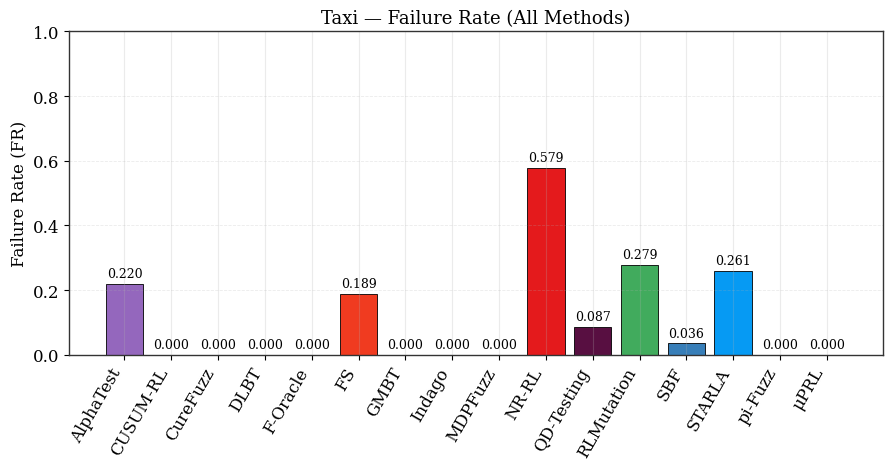

Saved FR plot.


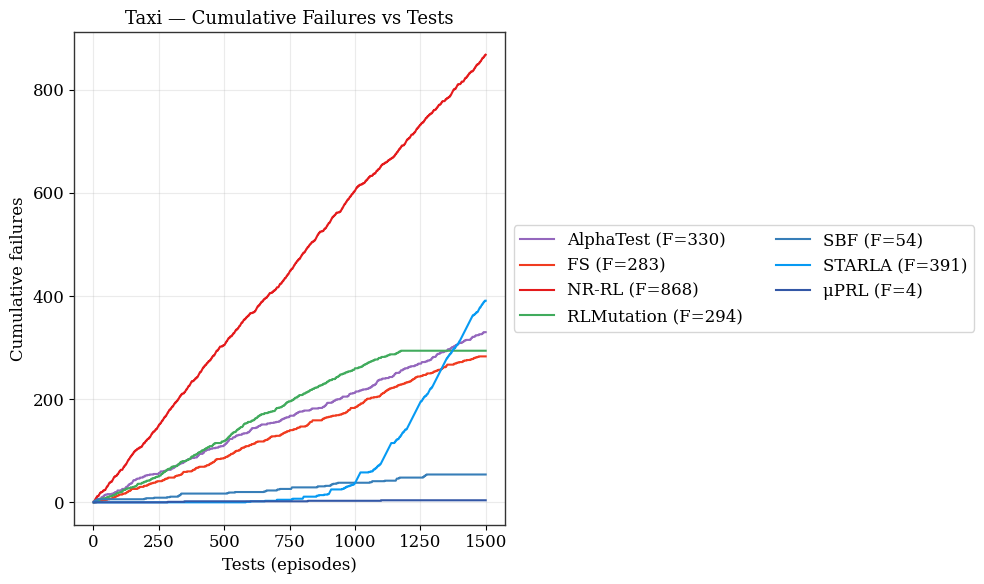

Saved: taxi_CF_tests


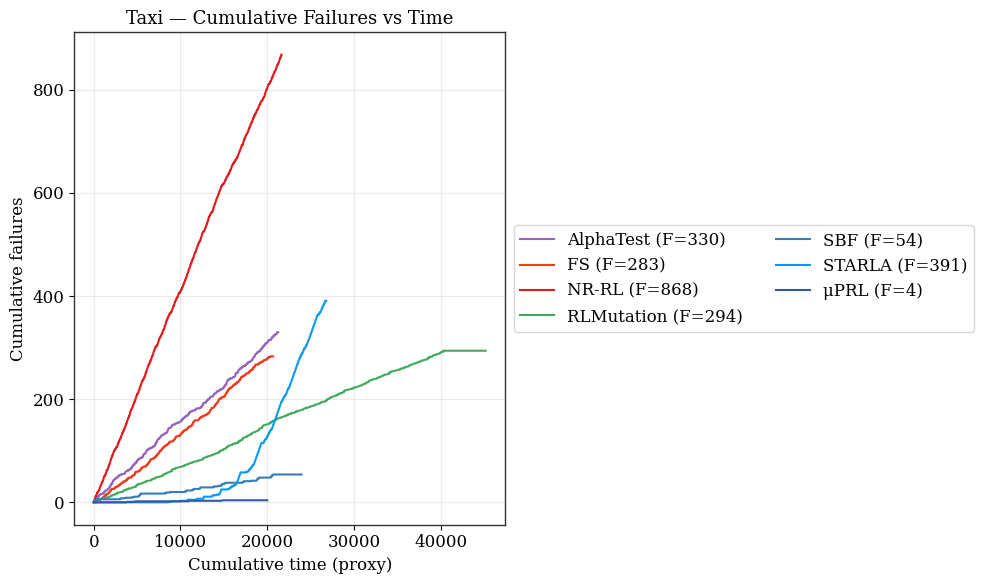

Saved: taxi_CF_time


In [12]:
# results
# =========================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


TABLES_DIR = TABLES_DIR
FIGS_DIR   = FIGS_DIR
RESULTS_DIR = RESULTS_DIR
os.makedirs(TABLES_DIR, exist_ok=True)
os.makedirs(FIGS_DIR, exist_ok=True)

TEST_BUDGET = 1500

# Colors
# ---------------------------------------------------------
COL = {
    "AdaStop":"#808000","F-Oracle":"#000080","CUSUM-RL":"#DDA0DD","DLBT":"#008000","MDPMorph":"#B56576",
    "QD-Testing":"#580F41","STARLA":"#069AF3","Indago":"#40E0D0","AlphaTest":"#9467bd",
    "NR-RL":"#e41a1c","SBF":"#377eb8",
    "MDPFuzz":"#984ea3","pi-Fuzz":"#ff7f00","GMBT":"#a65628","CureFuzz":"#f781bf",
    "RLMutation":"#41ab5d","FS":"#f03b20","μPRL":"#3357A6",
}
def _col(n): return COL.get(n, "#777")

# Theme
# ---------------------------------------------------------
plt.rcParams.update({
    "figure.figsize": (10.5, 4.2),
    "font.family": "serif",
    "font.serif": ["DejaVu Serif","Nimbus Roman","Times"],
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "axes.edgecolor":"#333",
    "axes.linewidth":1.0,
    "axes.grid": True,
    "grid.alpha": .25,
})

# 1) SINGLE TABLE (18 frameworks)
# ---------------------------------------------------------
results_df = pd.DataFrame(ALL_RESULTS)

# keep one row per framework
results_df = (
    results_df
    .sort_values(["framework"])
    .drop_duplicates("framework", keep="first")
    .reset_index(drop=True)
)

out_csv = TABLES_DIR / "taxi_all_frameworks_metrics.csv"
results_df.to_csv(out_csv, index=False)

display(results_df)
print("Saved table:", out_csv)

# 2) FR BAR PLOT
# ---------------------------------------------------------
fr_df = results_df[["framework","FR"]].copy()
fr_df["FR"] = pd.to_numeric(fr_df["FR"], errors="coerce").fillna(0.0)

plt.figure(figsize=(10.5,4.2))
bars = plt.bar(
    fr_df["framework"],
    fr_df["FR"],
    color=[_col(f) for f in fr_df["framework"]],
    edgecolor="black",
    linewidth=0.6
)
plt.ylabel("Failure Rate (FR)")
plt.ylim(0, max(1.0, fr_df["FR"].max()*1.1 if len(fr_df) else 1.0))
plt.title("Taxi — Failure Rate (All Methods)")
plt.xticks(rotation=60, ha="right")
plt.grid(True, axis="y", alpha=.25, linestyle="--", linewidth=0.6)

for b,val in zip(bars, fr_df["FR"]):
    plt.text(
        b.get_x()+b.get_width()/2,
        b.get_height()+0.01,
        f"{val:.3f}",
        ha="center", va="bottom", fontsize=9
    )

for ext in (".png",".pdf"):
    plt.savefig(FIGS_DIR / f"taxi_FR_all{ext}", dpi=300, bbox_inches="tight")

plt.show(); plt.close()
print("Saved FR plot.")

# 3) CF CURVES (tests + time)
# ---------------------------------------------------------
def _safe_read(p):
    try:
        return pd.read_csv(p)
    except Exception:
        return None

def _canon(df):
    if df is None or "failure" not in df.columns:
        return None
    d = df.copy()
    d["failure"] = pd.to_numeric(d["failure"], errors="coerce").fillna(0).astype(int)
    d["steps"]   = pd.to_numeric(d.get("steps",1), errors="coerce").fillna(1).astype(float)
    if "wall_dt" in d.columns:
        d["wall_dt"] = pd.to_numeric(d["wall_dt"], errors="coerce").fillna(0.0)
    else:
        d["wall_dt"] = d["steps"]  # proxy
    if len(d) < TEST_BUDGET:
        pad = pd.DataFrame({
            "failure":[0]*(TEST_BUDGET-len(d)),
            "steps":[d["steps"].median() or 1.0]*(TEST_BUDGET-len(d)),
            "wall_dt":[d["wall_dt"].median() or 0.0]*(TEST_BUDGET-len(d)),
        })
        d = pd.concat([d,pad], ignore_index=True)
    return d.iloc[:TEST_BUDGET].reset_index(drop=True)

def cumulative_curve(df, axis="tests"):
    y = np.maximum.accumulate(df["failure"].cumsum().to_numpy())
    if axis=="tests":
        x = np.arange(1, len(df)+1)
    else:
        x = df["wall_dt"].cumsum().to_numpy()
    return x,y

raw_map = {}
for fw in results_df["framework"]:
    fw_raw = RESULTS_DIR / fw / "raw"
    if fw_raw.exists():
        cands = [fw_raw / f for f in os.listdir(fw_raw) if f.endswith(".csv")]
        if cands:
            raw_map[fw] = max(cands, key=lambda p: os.path.getsize(p))

def plot_cf(axis, fname):
    plt.figure(figsize=(10,6))
    plotted = 0
    for fw,p in raw_map.items():
        dfw = _canon(_safe_read(p))
        if dfw is None:
            continue
        F = int(dfw["failure"].sum())
        if F == 0:
            continue
        x,y = cumulative_curve(dfw, axis=axis)
        plt.plot(x, y, label=f"{fw} (F={F})", color=_col(fw), linestyle='-')
        plotted += 1

    plt.xlabel("Tests (episodes)" if axis=="tests" else "Cumulative time (proxy)")
    plt.ylabel("Cumulative failures")
    plt.title(f"Taxi — Cumulative Failures vs {'Tests' if axis=='tests' else 'Time'}")
    if plotted:
        plt.legend(loc="center left", bbox_to_anchor=(1,0.5), ncol=2)
    plt.grid(True, alpha=.25)
    plt.tight_layout()

    for ext in (".png",".pdf"):
        plt.savefig(FIGS_DIR / f"{fname}{ext}", dpi=300, bbox_inches="tight")

    plt.show(); plt.close()
    print("Saved:", fname)

plot_cf("tests", "taxi_CF_tests")
plot_cf("time",  "taxi_CF_time")